# <a id='toc1_'></a>[Binding site reactivity (via Nano-DMS-MaP)](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Binding site reactivity (via Nano-DMS-MaP)](#toc1_)    
  - [Summary](#toc1_1_)    
  - [Data Loading](#toc1_2_)    
  - [Visualization of reactivity (gggenomes)](#toc1_3_)    
  - [Correlation analysis](#toc1_4_)    
    - [Correlation of binding site reactivity and PLP efficiency](#toc1_4_1_)    
    - [Correlation of junction reactivity and PLP efficiency](#toc1_4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Summary](#toc0_)

The reactivity of binding sites is drastically reduced, when PLPs are bound.
This indicates, that binding indeed happens in the expected locations.
There is a correlation between binding site reactivity (without PLP) and PLP efficiency (defined here as the median number of spots per cell when only this specific PLP is used, [see the plp_individual results](../spot_analysis/plp_individual.ipynb)).
A possible explanation is, that regions with higher reactivity are more easily accessible, which facilitates PLP binding.

In [1]:
library(tidyverse)
library(RcppRoll)
library(gggenomes)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gggenomes’


The following object is masked from ‘package:dplyr’:

    pick


The following object is masked from ‘package:graphics’:

    layout




In [2]:
options(repr.plot.res = 300, repr.plot.width=8, repr.plot.height=4)
theme_set(theme_light())
theme_update(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black'))

## <a id='toc1_2_'></a>[Data Loading](#toc0_)

In [3]:
reactivities <- read_csv("data/nano-dms-map/supp-data2-dms_reactivities.csv") %>%
  select(-`...1`) %>%
  group_by(group) %>%
  mutate(pos=row_number()) %>%
  ungroup() %>%
  separate(group, into=c("group", "strain", "segment"), sep="_")

New names:
• `` -> `...1`
Rows: 6376 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): group, sequence
dbl (2): ...1, reactivities

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
reactivities_by_segment <- function(reactivities, segment){
  reactivities %>%
    filter(segment == .env$segment) %>%
    select(group, pos, reactivities) %>%
    group_by(group) %>%
    mutate(rm = roll_mean(reactivities, 20, fill=NA, na.rm=T))
}

In [5]:
reactivities_ha <- reactivities_by_segment(reactivities, "HA")
reactivities_na <- reactivities_by_segment(reactivities, "NA")

In [6]:
reactivity_diff <- . %>%
  filter(between(pos, 30, max(pos)-30)) %>% # filter out the first and last 30 positions
  ungroup() %>%
  select(-reactivities) %>%
  pivot_wider(names_from=group, values_from=rm) %>%
  mutate(diff=NoPLP-PLP)

In [7]:
reactivities_ha_diff_w20 <- reactivity_diff(reactivities_ha)
reactivities_na_diff_w20 <- reactivity_diff(reactivities_na)

In [8]:
efficiency <- read_tsv("figures/fig2cd-plp_individual-spot_counts_NA-summary.tsv", na="") %>%
  bind_rows(read_tsv("figures/supp-fig2cd-plp_individual-spot_counts_HA-summary.tsv")) %>%
  filter(sample_type=="positive")

Rows: 20 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): segment, sample_type
dbl (7): plp, q25, median, q75, mean, sd, n_fovs

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): segment, sample_type
dbl (7): plp, q25, median, q75, mean, sd, n_fovs

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
plps <- read_csv("data/nano-dms-map/plp_binding_regions.csv", na="") %>%
  left_join(efficiency) %>%
  rename(
    seq_id = segment,
    efficiency = median
  )

Rows: 20 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): segment, vRNA_sequence, PLP_sequence, 5' Arm, 3' Arm, Junction posi...
dbl (3): plp, start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(segment, plp)`


In [10]:
segments = tibble(seq_id=c("NA","HA"), length=c(max(reactivities_na$pos), max(reactivities_ha$pos)))

In [11]:
reactivity_feat_na <- reactivities_na_diff_w20 %>% mutate(seq_id="NA", start=pos, end=pos+1)
reactivity_feat_ha <- reactivities_ha_diff_w20 %>% mutate(seq_id="HA", start=pos, end=pos+1)

## <a id='toc1_3_'></a>[Visualization of reactivity (gggenomes)](#toc0_)

Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
wiggle bounds
• mid:  -0.0534722222222223
• low:  -0.125991071428571
• high: 0.356321726190476
wiggle bounds
• mid:  0.559828125
• low:  0.342234375
• high: 0.73892375
wiggle bounds
• mid:  0.562614583333333
• low:  0.222059375
• high: 0.809041666666667


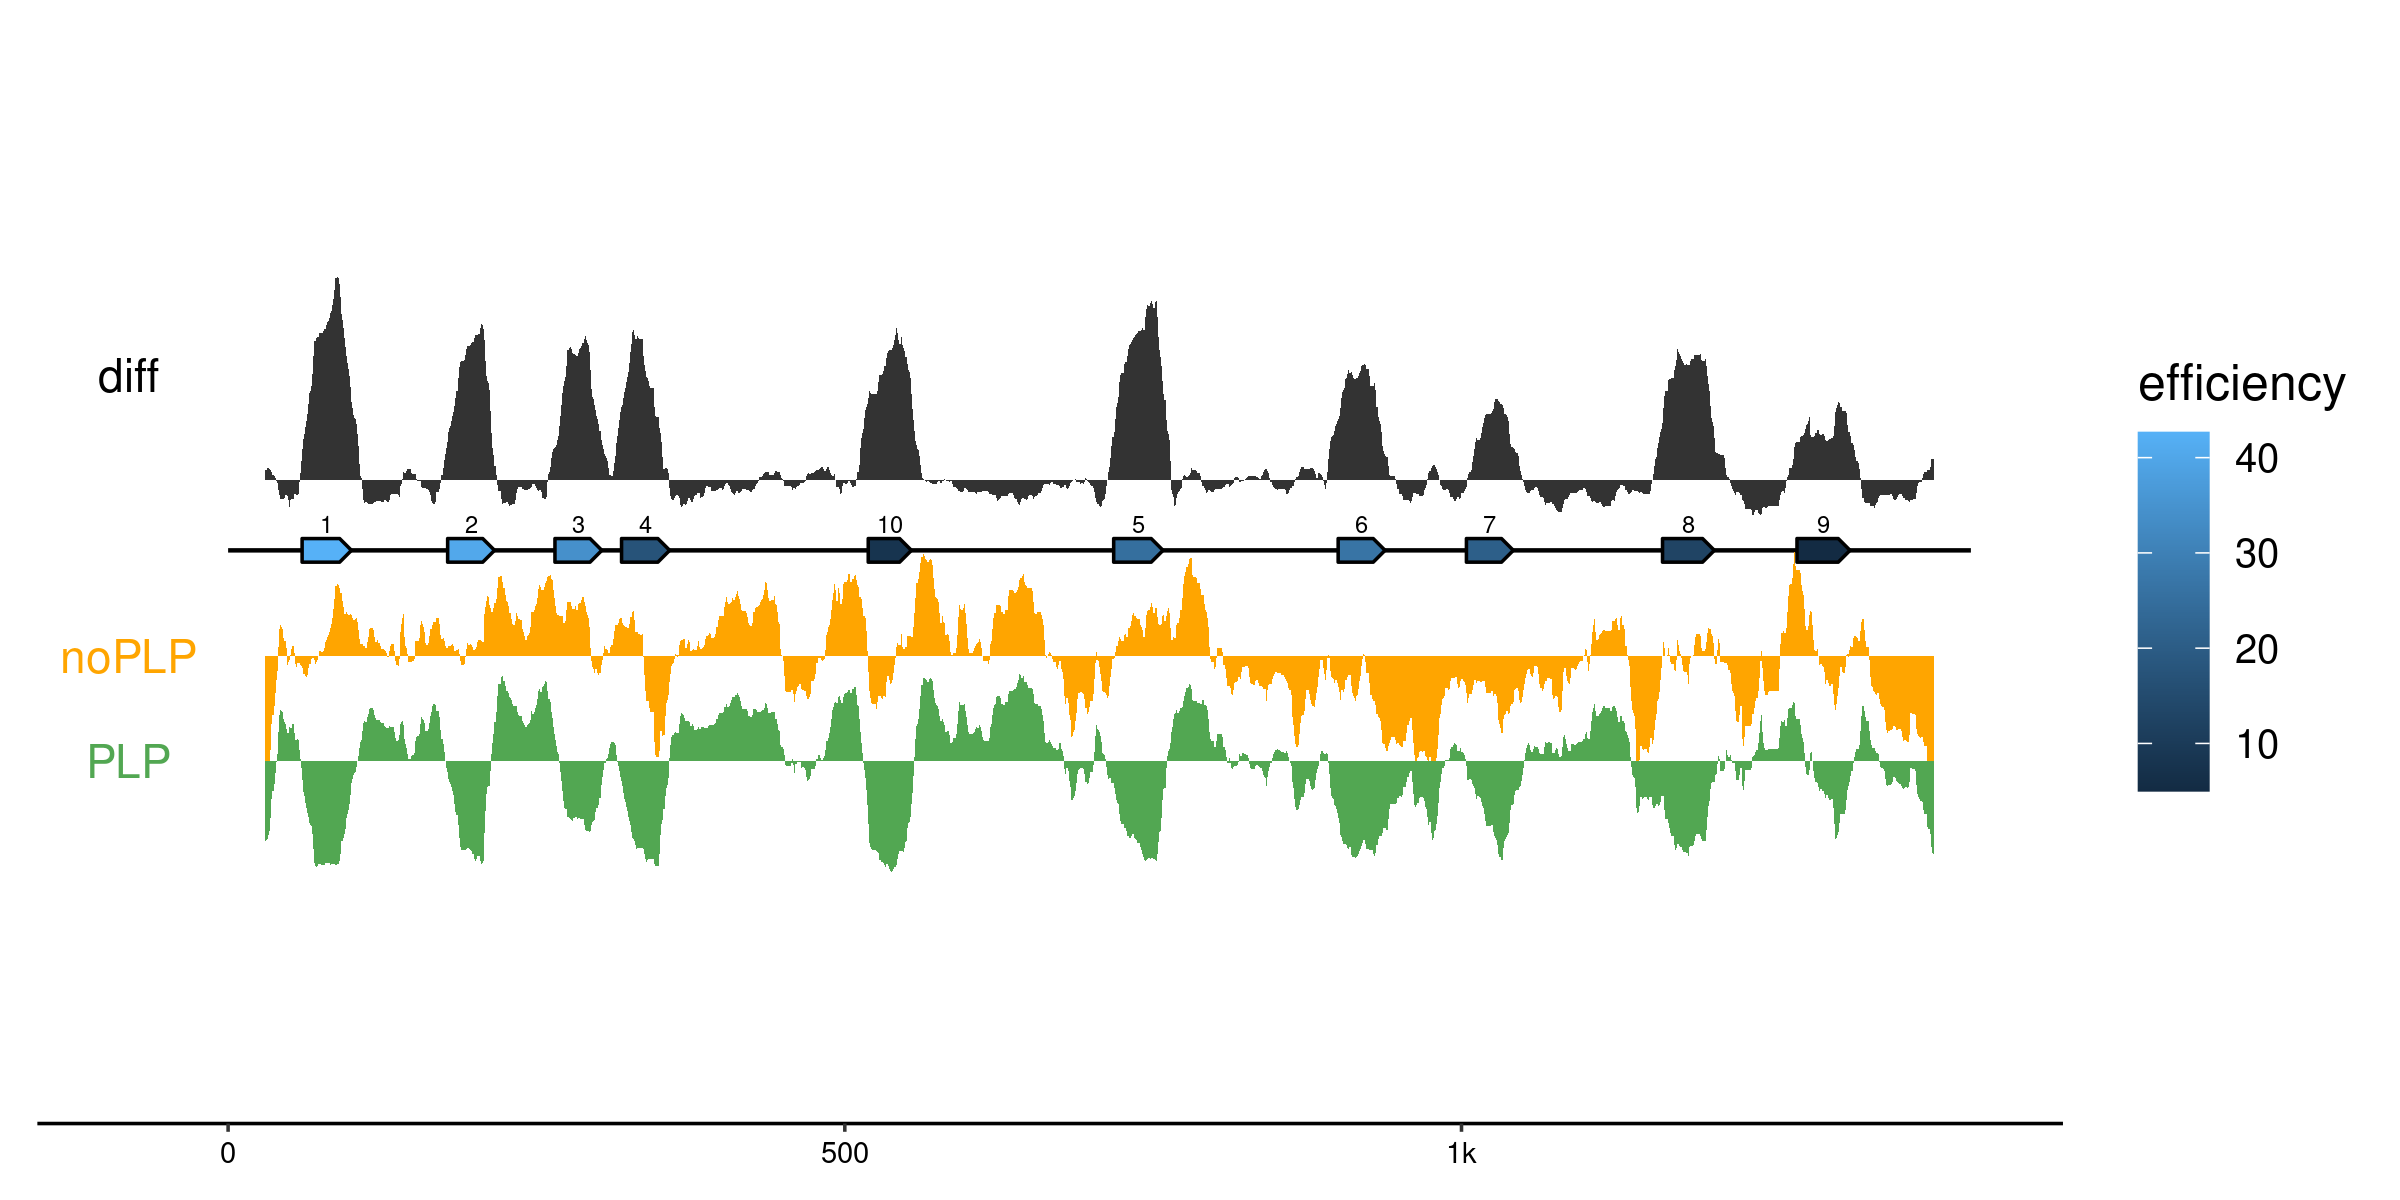

In [12]:
gggenomes(plps, seqs=segments, feats = reactivity_feat_na) %>%
  pick_seqs("NA") +
  geom_seq() +
  geom_gene(aes(fill=efficiency)) +
  geom_wiggle(aes(z=diff), position=position_nudge(y=.2), height=.5) +
  geom_wiggle(aes(z=NoPLP), position=position_nudge(y=-.3), height=.5, fill="orange") +
  geom_wiggle(aes(z=PLP), position=position_nudge(y=-.6), height=.5, fill="#52a752") +
  geom_gene_tag(aes(label=plp), angle=0, hjust=.5, nudge_y=.05, check_overlap = TRUE, size=2) +
  annotate("text", x = -80, y = 1.5, label = "diff") +
  annotate("text", x = -80, y = .7, label = "noPLP", color="orange") +
  annotate("text", x = -80, y = .4, label = "PLP", color="#52a752") +
  NULL

In [13]:
ggsave("figures/fig3b-plp_reactivities-NA.svg", width = 8, height = 4, dpi = 300)

Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
wiggle bounds
• mid:  -0.0534722222222223
• low:  -0.125991071428571
• high: 0.356321726190476
wiggle bounds
• mid:  0.559828125
• low:  0.342234375
• high: 0.73892375
wiggle bounds
• mid:  0.562614583333333
• low:  0.222059375
• high: 0.809041666666667


Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
wiggle bounds
• mid:  -0.0156833333333334
• low:  -0.18755969551282
• high: 0.260084595959596
wiggle bounds
• mid:  0.424337662337662
• low:  0.248932142857143
• high: 0.624010912698413
wiggle bounds
• mid:  0.423823076923077
• low:  0.1816625
• high: 0.667758680555556


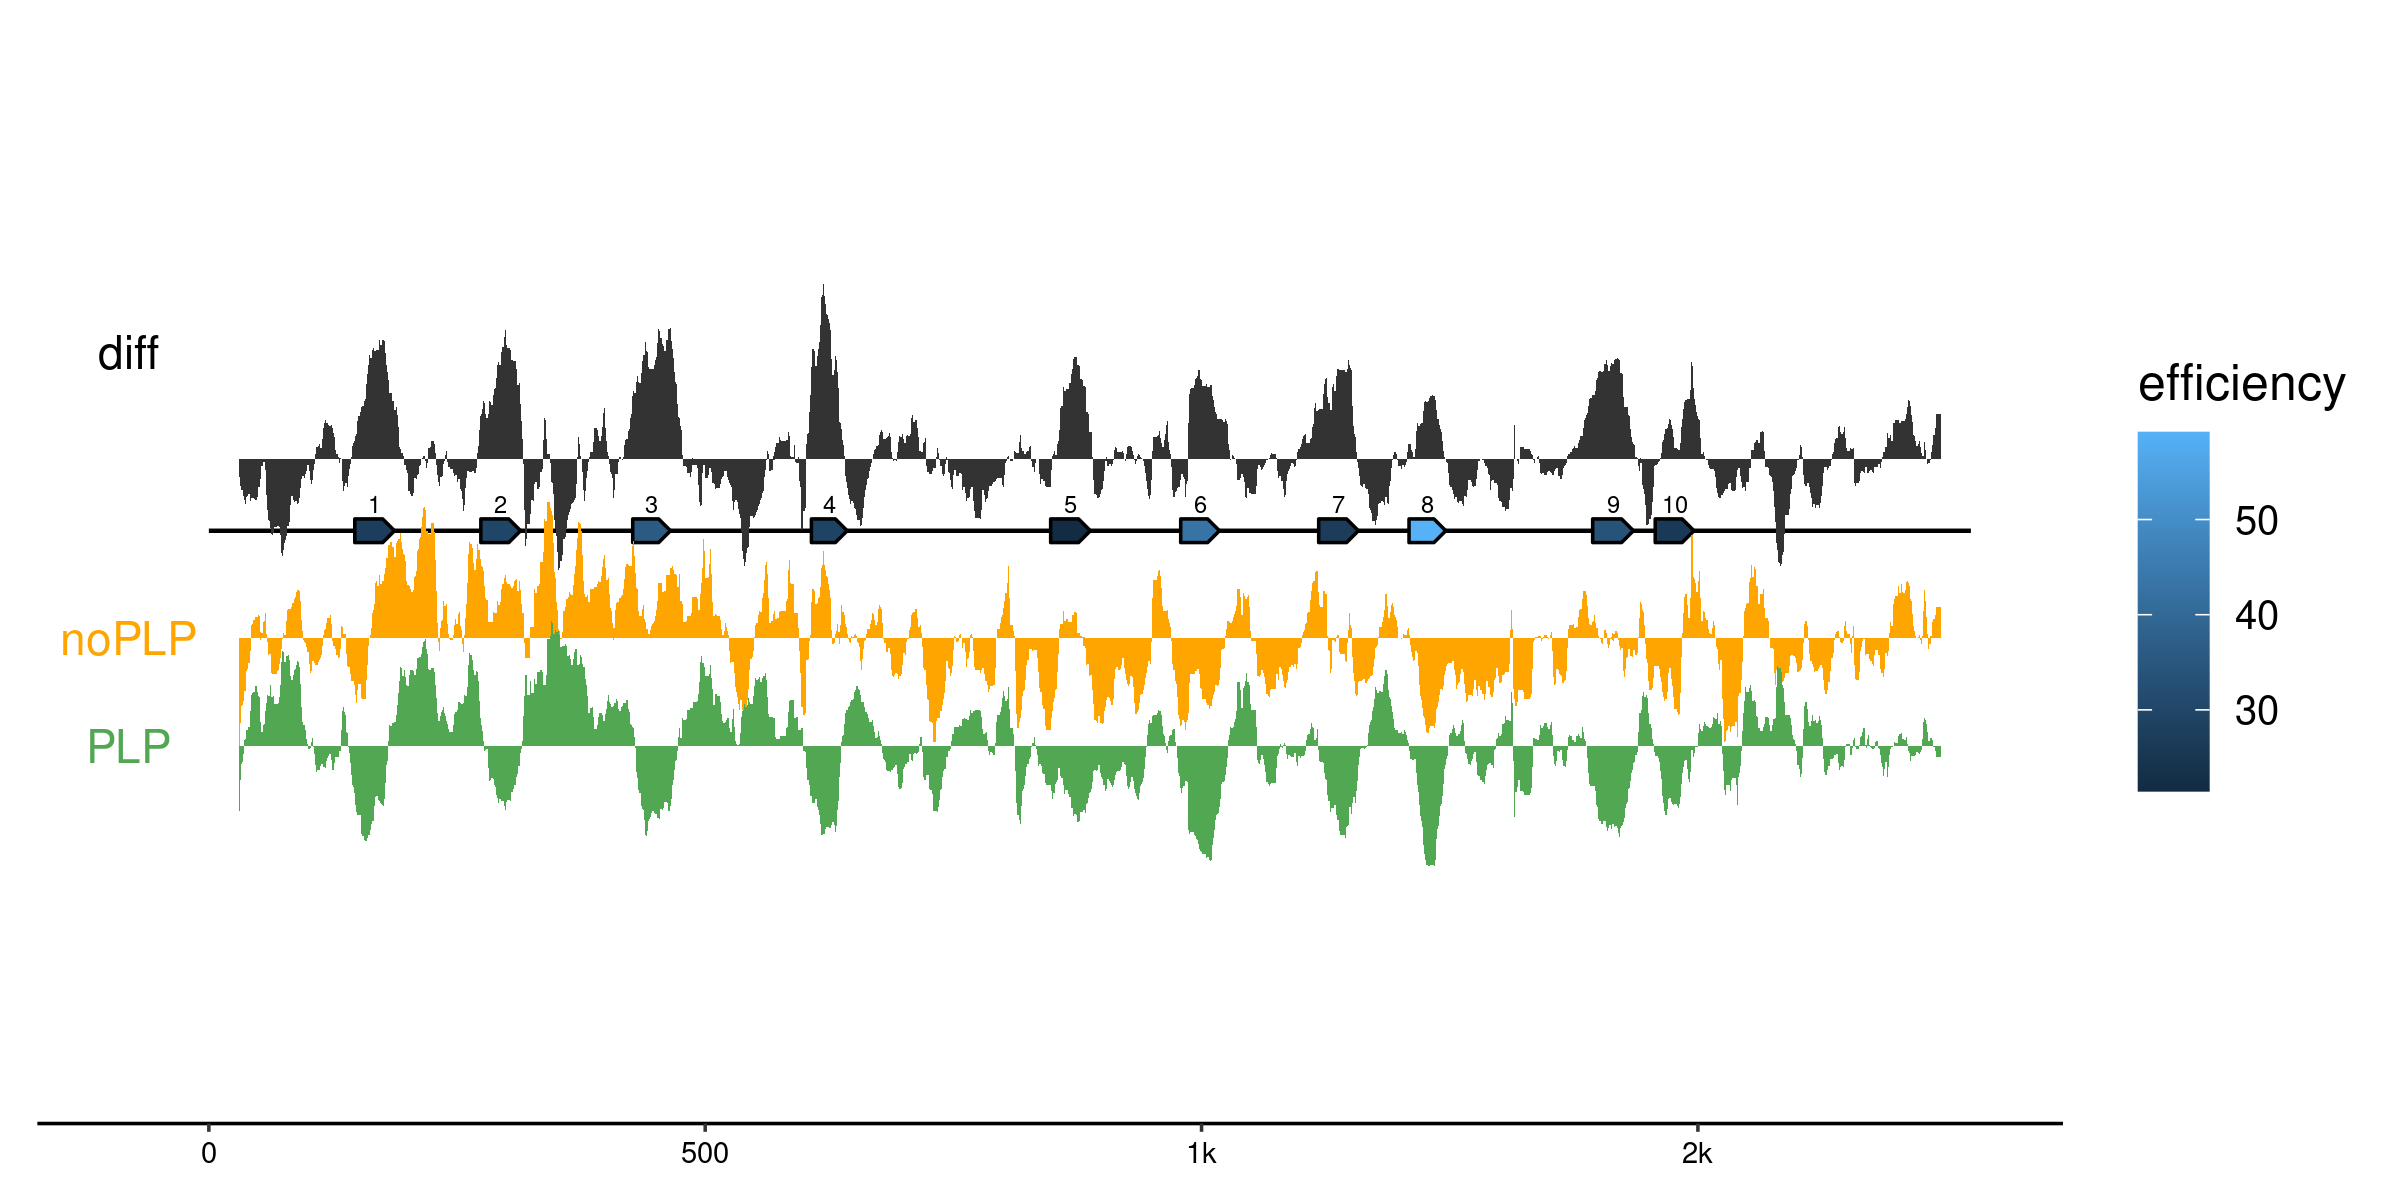

In [14]:
gggenomes(plps, seqs=segments, feats = reactivity_feat_ha) %>%
  pick_seqs("HA") +
  geom_seq() +
  geom_gene(aes(fill=efficiency)) +
  geom_wiggle(aes(z=diff), position=position_nudge(y=.2), height=.5) +
  geom_wiggle(aes(z=NoPLP), position=position_nudge(y=-.3), height=.5, fill="orange") +
  geom_wiggle(aes(z=PLP), position=position_nudge(y=-.6), height=.5, fill="#52a752") +
  geom_gene_tag(aes(label=plp), angle=0, hjust=.5, nudge_y=.05, check_overlap = TRUE, size=2) +
  annotate("text", x = -80, y = 1.5, label = "diff") +
  annotate("text", x = -80, y = .7, label = "noPLP", color="orange") +
  annotate("text", x = -80, y = .4, label = "PLP", color="#52a752") +
  NULL

In [15]:
ggsave("figures/supp-fig4a-plp_reactivities-HA.svg", width = 8, height = 4, dpi = 300)

Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
Only saw `type=NA` in genes and will treat everything as `type="CDS"`.
wiggle bounds
• mid:  -0.0156833333333334
• low:  -0.18755969551282
• high: 0.260084595959596
wiggle bounds
• mid:  0.424337662337662
• low:  0.248932142857143
• high: 0.624010912698413
wiggle bounds
• mid:  0.423823076923077
• low:  0.1816625
• high: 0.667758680555556


## <a id='toc1_4_'></a>[Correlation analysis](#toc0_)

### <a id='toc1_4_1_'></a>[Correlation of binding site reactivity and PLP efficiency](#toc0_)

#### NA

In [16]:
correlation_region_reactivity_na <- reactivities_na_diff_w20 %>%
  left_join(filter(plps, seq_id=="NA"), join_by(between(pos, start, end))) %>%
  filter(!is.na(plp)) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  corrr::correlate() %>%
  corrr::focus(efficiency) %>%
  filter(term!="plp")

correlation_region_reactivity_na

Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


term,efficiency
<chr>,<dbl>
NoPLP,0.4342581
PLP,-0.1630581
diff,0.4649112


`geom_smooth()` using formula = 'y ~ x'


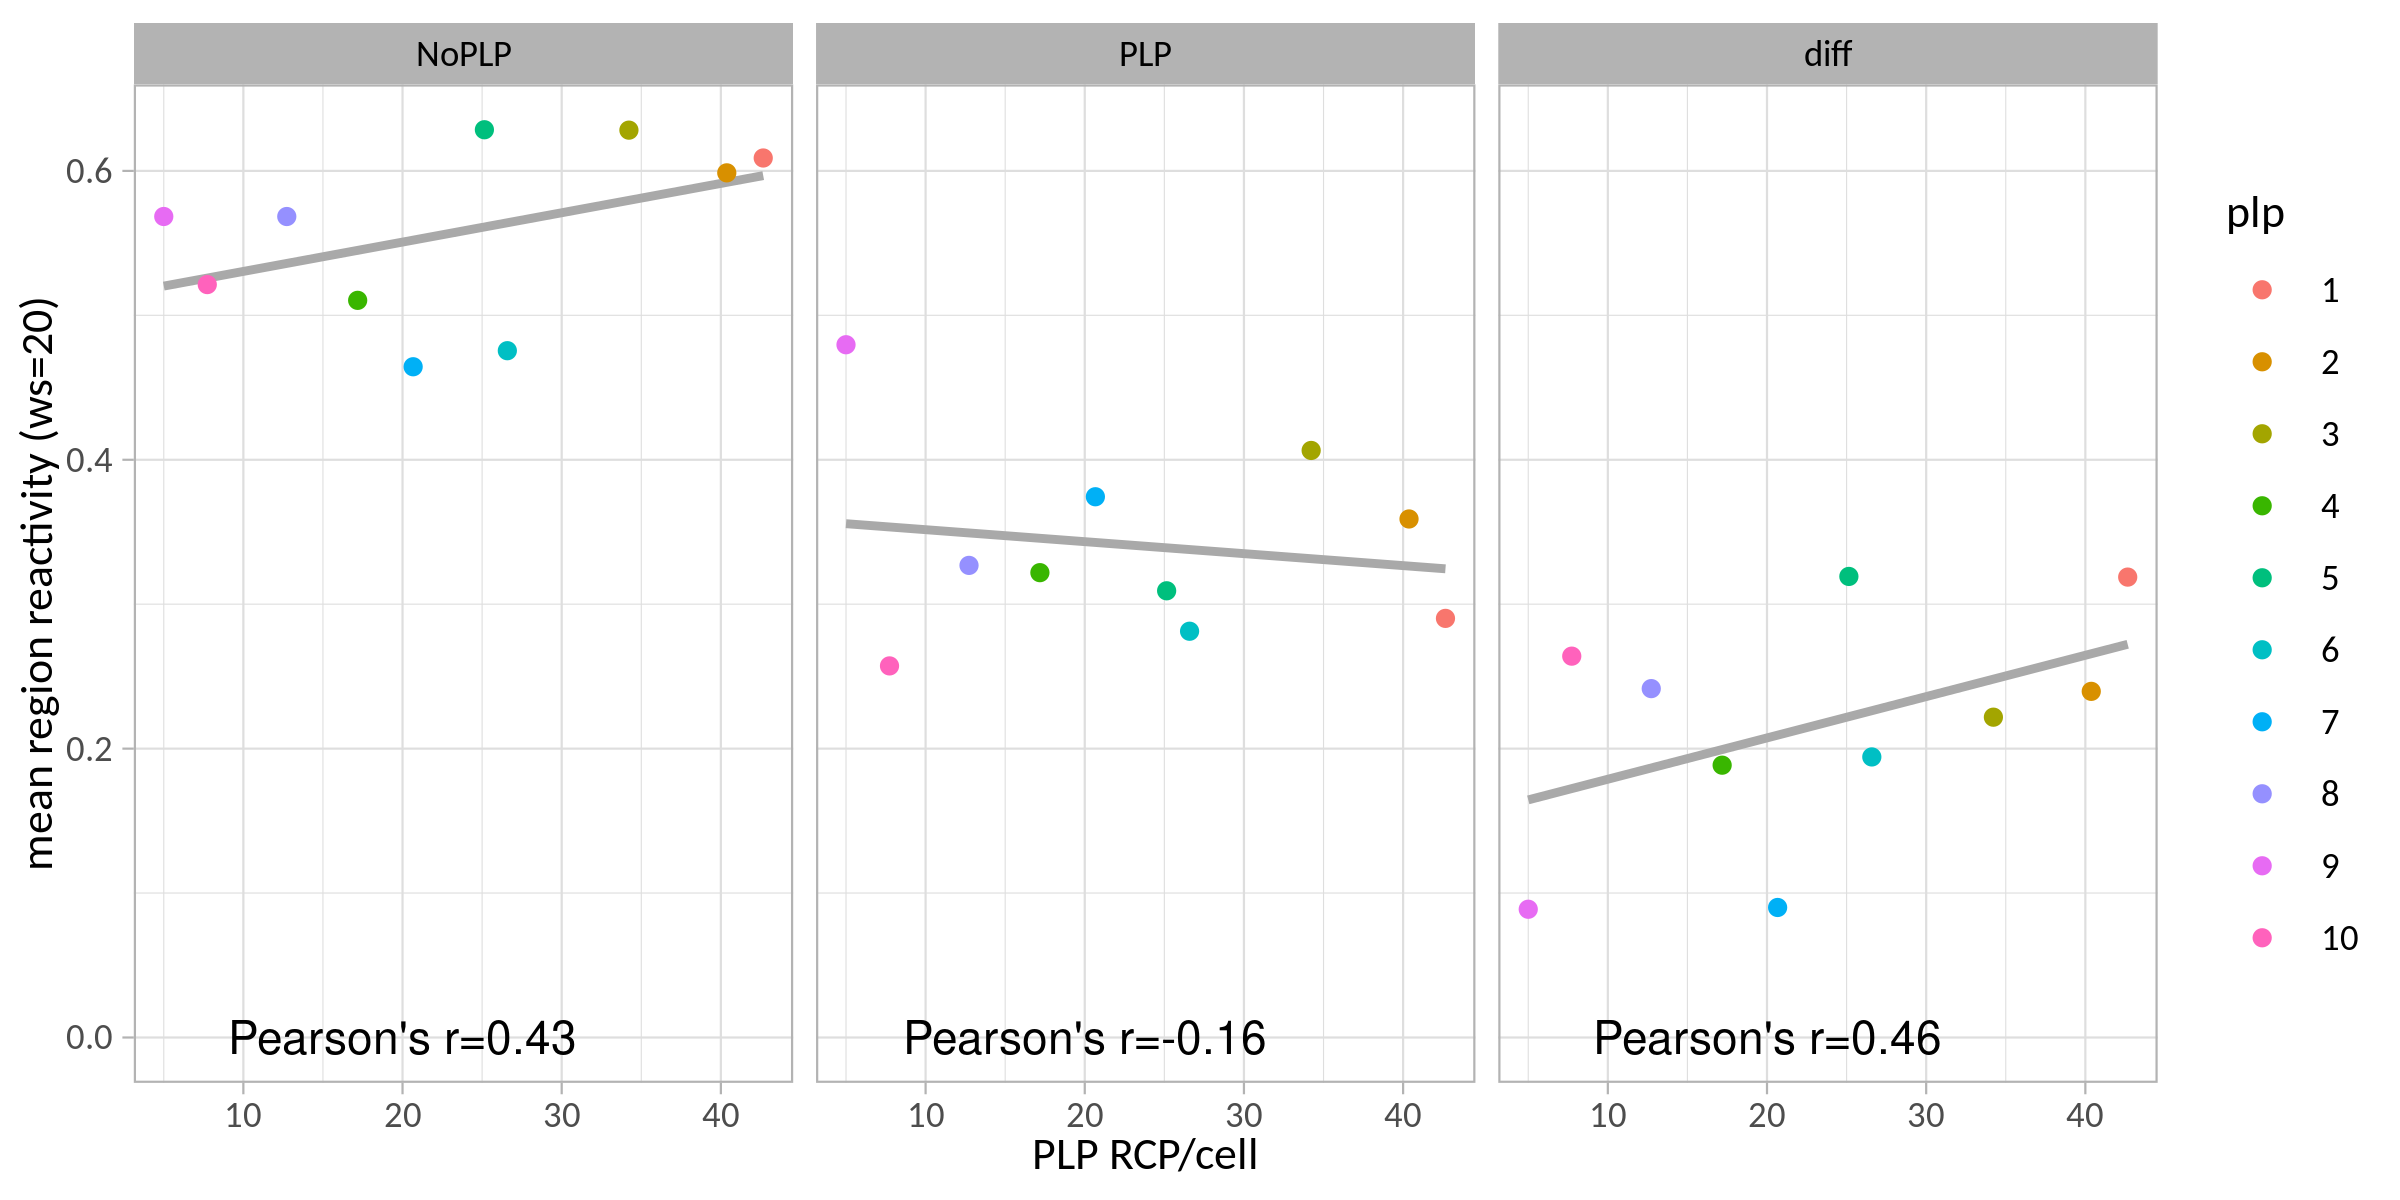

In [17]:
reactivities_na_diff_w20 %>%
  left_join(filter(plps, seq_id=="NA"), join_by(between(pos, start, end))) %>%
  filter(!is.na(plp)) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  pivot_longer(NoPLP:diff,values_to="mean reactivity") %>%
  mutate(plp = as_factor(plp)) %>%
  mutate(name = fct_relevel(name, "NoPLP", "PLP")) %>%
  ggplot(aes(efficiency, `mean reactivity`)) +
    geom_smooth(method="lm", se=FALSE, color="darkgray") +
    geom_point(aes(color=plp)) +
    facet_grid(.~name) +
    geom_text(data=mutate(correlation_region_reactivity_na,name=term,x=20,y=0,efficiency=round(efficiency,2),name=fct_relevel(name,"NoPLP","PLP")), aes(x=x,y=y,label=str_glue("Pearson's r={efficiency}")), inherit.aes = FALSE) +
    ylab("mean region reactivity (ws=20)") +
    xlab("PLP RCP/cell")

In [18]:
ggsave("figures/fig3c-plp_reactivity_efficiency_correlation-NA.svg", width = 8, height = 4, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'


#### HA

**TODO** PLP 6 and 8 are excluded - justify this decision

In [25]:
correlation_region_reactivity_ha <- reactivities_ha_diff_w20 %>%
  left_join(filter(plps, seq_id=="HA"), join_by(between(pos, start, end))) %>%
  filter(!is.na(plp), !(plp %in% c(6,8))) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  corrr::correlate() %>%
  corrr::focus(efficiency) %>%
  filter(term!="plp")

correlation_region_reactivity_ha

Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


term,efficiency
<chr>,<dbl>
NoPLP,0.4881367
PLP,-0.3934178
diff,0.6628707


`geom_smooth()` using formula = 'y ~ x'


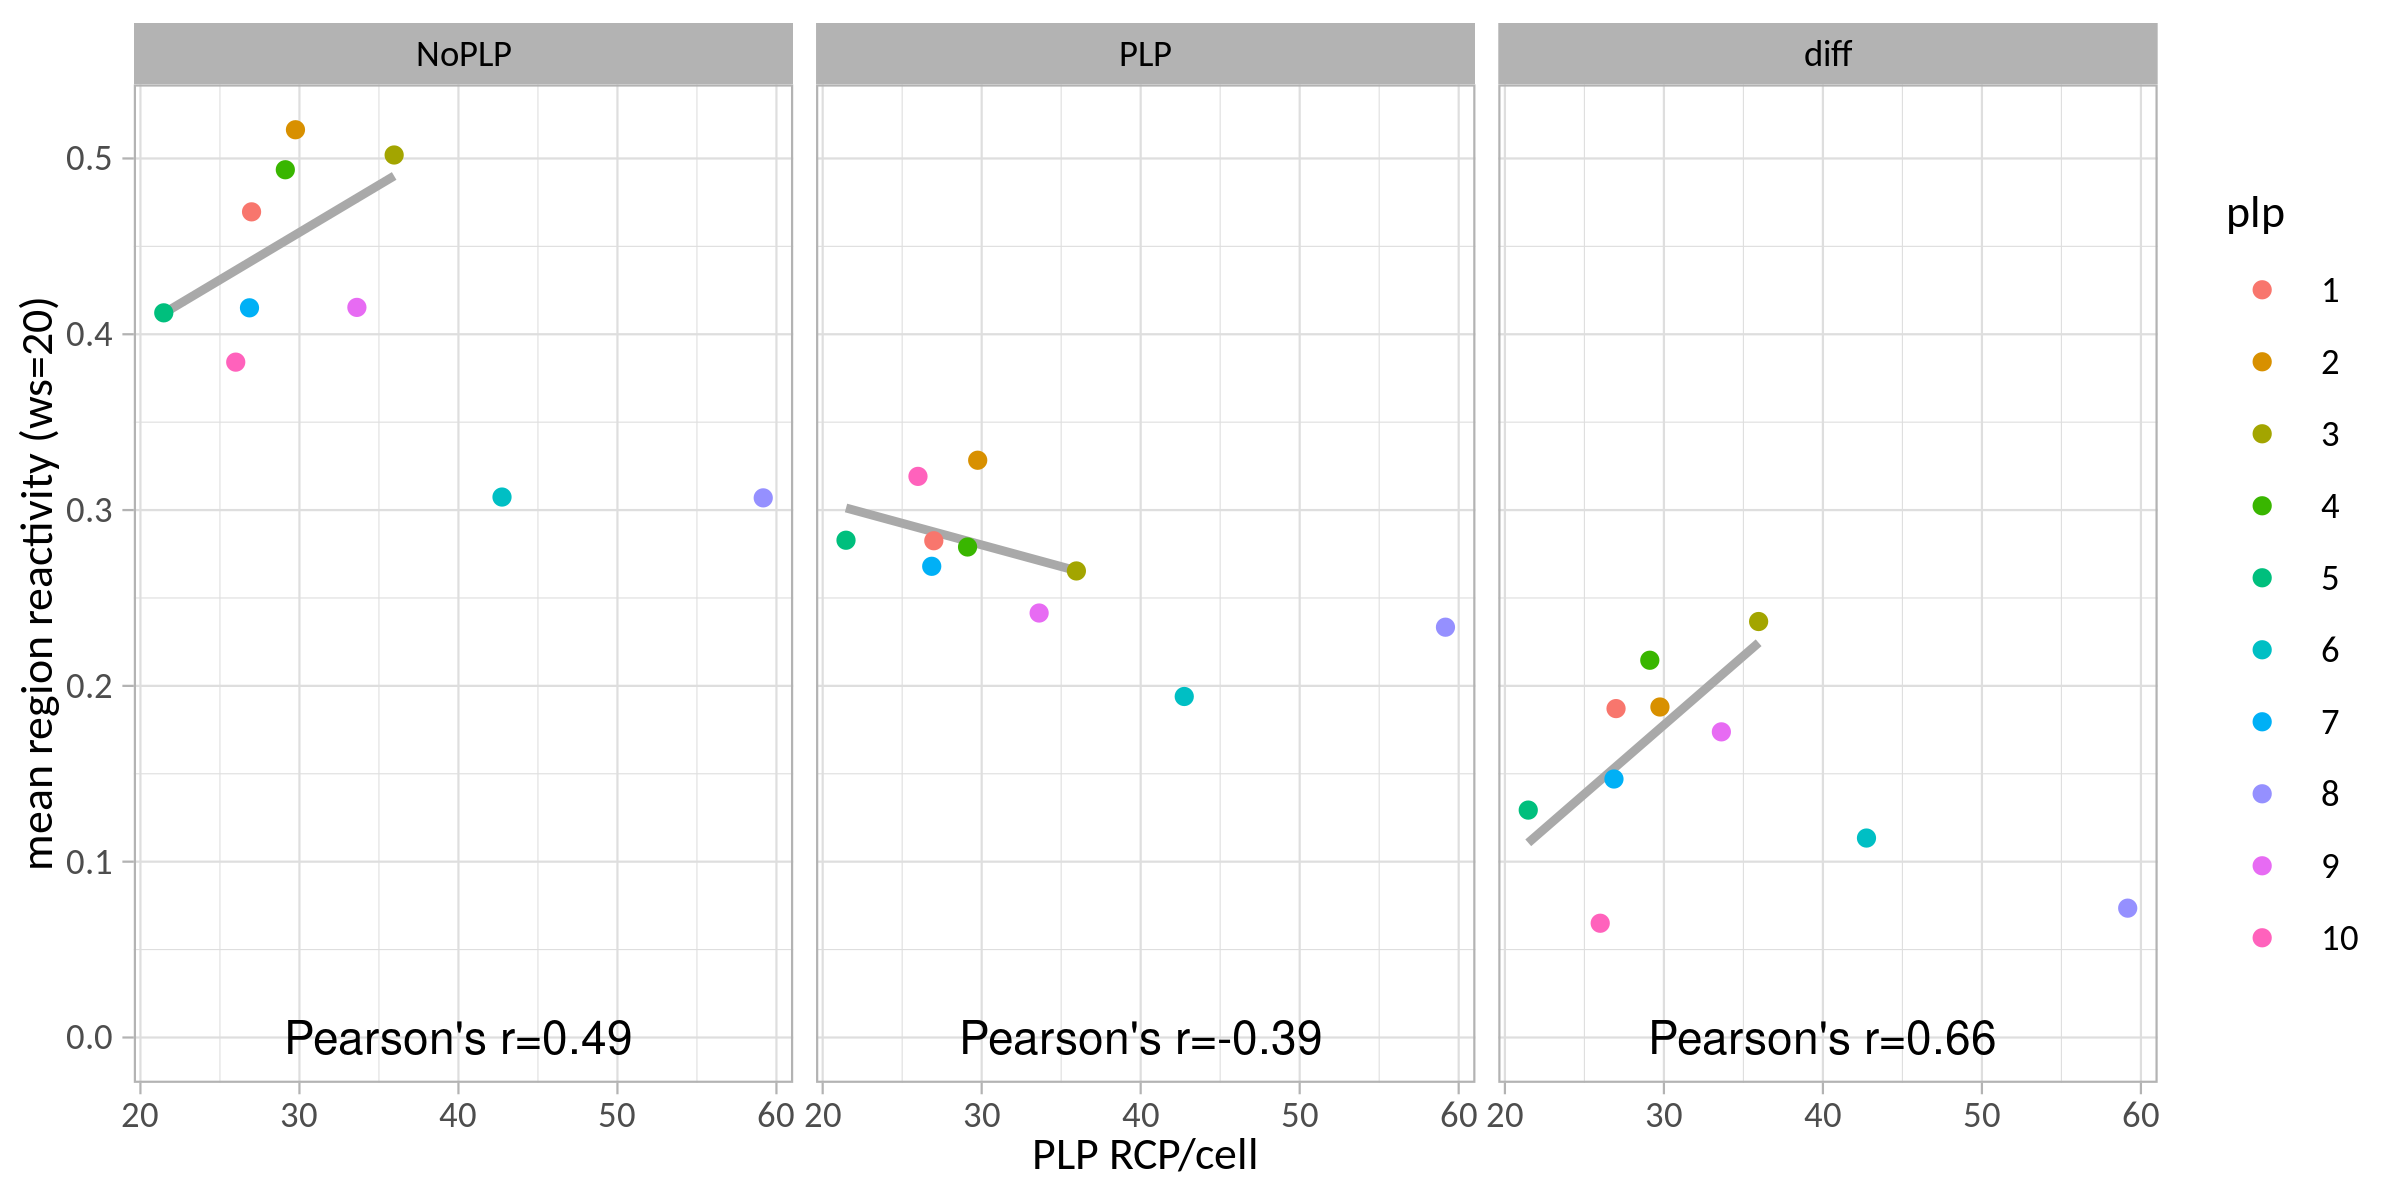

In [32]:
reactivities_ha_diff_w20 %>%
  left_join(filter(plps, seq_id=="HA"), join_by(between(pos, start, end))) %>%
  filter(!is.na(plp)) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  pivot_longer(NoPLP:diff,values_to="mean reactivity") %>%
  mutate(plp = as_factor(plp)) %>%
  mutate(name = fct_relevel(name, "NoPLP", "PLP")) %>%
  ggplot(aes(efficiency, `mean reactivity`)) +
    geom_smooth(data=. %>% filter(!plp %in% c(6,8)), method="lm", se=FALSE, color="darkgray") +
    geom_point(aes(color=plp)) +
    facet_grid(.~name) +
    geom_text(data=mutate(correlation_region_reactivity_ha,name=term,x=40,y=0,efficiency=round(efficiency,2),name=fct_relevel(name,"NoPLP","PLP")), aes(x=x,y=y,label=str_glue("Pearson's r={efficiency}")), inherit.aes = FALSE) +
    ylab("mean region reactivity (ws=20)") +
    xlab("PLP RCP/cell")

In [22]:
ggsave("figures/supp-fig4b-plp_reactivity_efficiency_correlation-HA.svg", width = 8, height = 4, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'


### <a id='toc1_4_2_'></a>[Correlation of junction reactivity and PLP efficiency](#toc0_)

#### NA

In [23]:
junctions_na <- plps %>%
  filter(seq_id=="NA") %>%
  select(plp, pos=`Junction position (nt)`, efficiency) %>% separate_rows(pos, sep="-", convert=TRUE)

In [24]:
correlation_junction_reactivity <- reactivities_na_diff_w20 %>%
  left_join(junctions_na) %>%
  filter(!is.na(plp)) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  corrr::correlate() %>%
  corrr::focus(efficiency) %>%
  filter(term!="plp")

correlation_junction_reactivity

Joining with `by = join_by(pos)`
Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


term,efficiency
<chr>,<dbl>
NoPLP,0.5790776
PLP,-0.2330223
diff,0.6040137


Joining with `by = join_by(pos)`


`geom_smooth()` using formula = 'y ~ x'


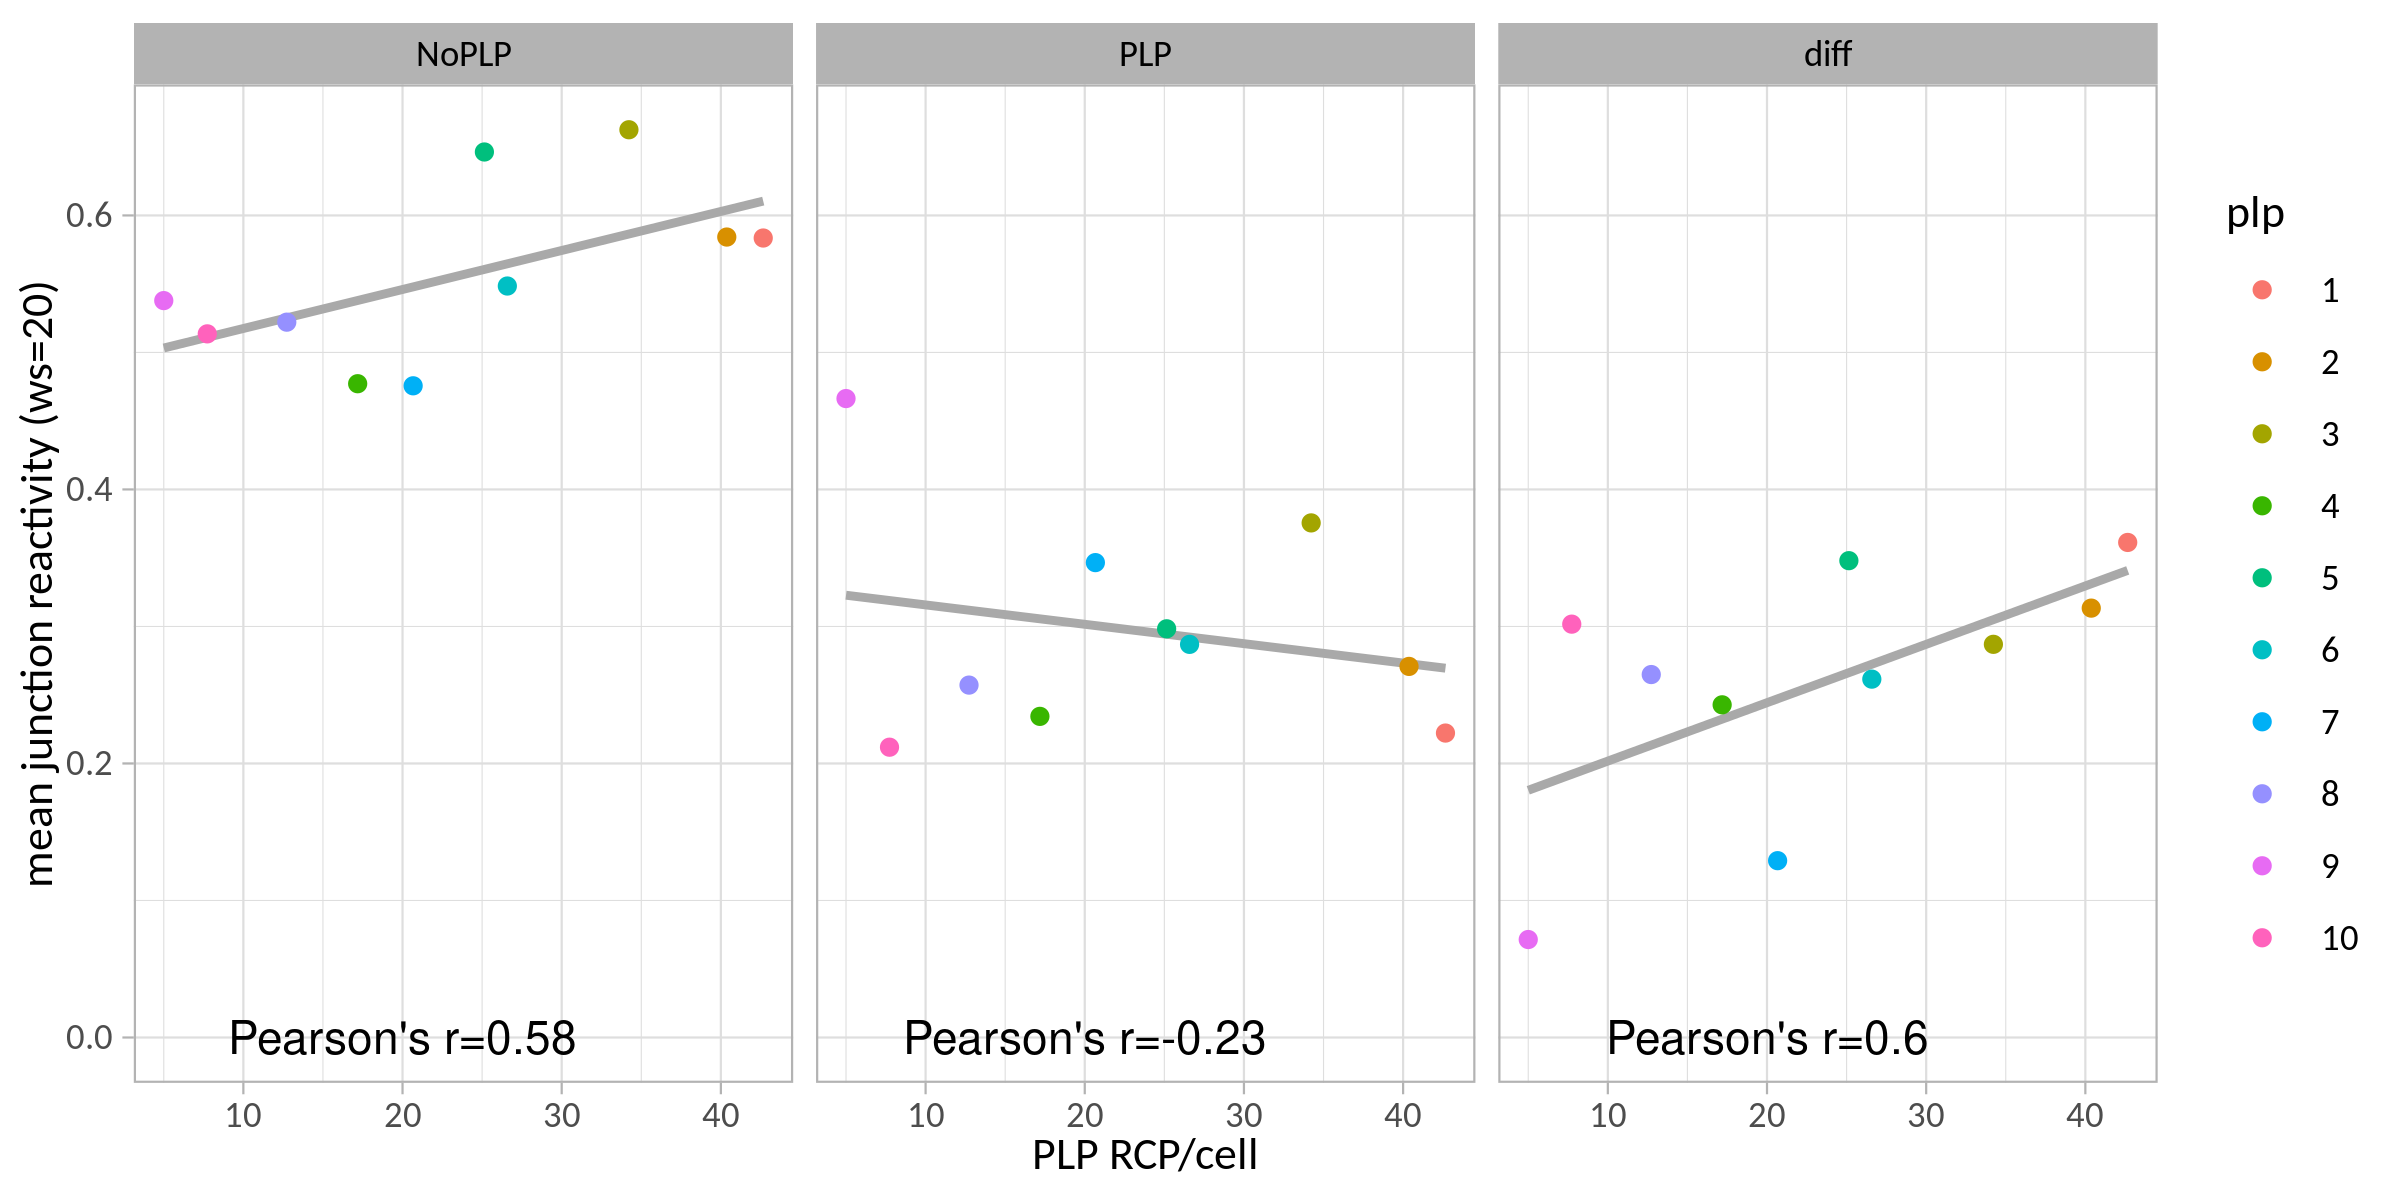

In [25]:
reactivities_na_diff_w20 %>%
  left_join(junctions_na) %>%
  filter(!is.na(plp)) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  mutate(plp = as_factor(plp)) %>%
  pivot_longer(NoPLP:diff,values_to="mean reactivity") %>%
  mutate(name = fct_relevel(name, "NoPLP", "PLP")) %>%
  ggplot(aes(efficiency, `mean reactivity`)) +
    geom_smooth(method="lm", se=FALSE, color="darkgray") +
    geom_point(aes(color=plp)) +
    facet_wrap(name~.) +
    geom_text(data=mutate(correlation_junction_reactivity,name=term,x=20,y=0,efficiency=round(efficiency,2),name=fct_relevel(name,"NoPLP","PLP")), aes(x=x,y=y,label=str_glue("Pearson's r={efficiency}")), inherit.aes = FALSE) +
    ylab("mean junction reactivity (ws=20)") +
    xlab("PLP RCP/cell")

In [26]:
ggsave("figures/supp-fig3a-plp_reactivity_efficiency_correlation-junction-NA.svg", width = 8, height = 4, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'


#### HA

In [33]:
junctions_ha <- plps %>%
  filter(seq_id=="HA") %>%
  select(plp, pos=`Junction position (nt)`, efficiency) %>% separate_rows(pos, sep="-", convert=TRUE)

**TODO** PLP 6 and 8 are excluded - justify this decision (also this plot and the correlations do not match the ones in the manuscript)

In [42]:
correlation_junction_reactivity <- reactivities_ha_diff_w20 %>%
  left_join(junctions_ha) %>%
  filter(!is.na(plp), !plp %in% c(6,8)) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  corrr::correlate() %>%
  corrr::focus(efficiency) %>%
  filter(term!="plp")

correlation_junction_reactivity

Joining with `by = join_by(pos)`


Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


term,efficiency
<chr>,<dbl>
NoPLP,0.1312638
PLP,-0.4278051
diff,0.3001889


Joining with `by = join_by(pos)`
`geom_smooth()` using formula = 'y ~ x'


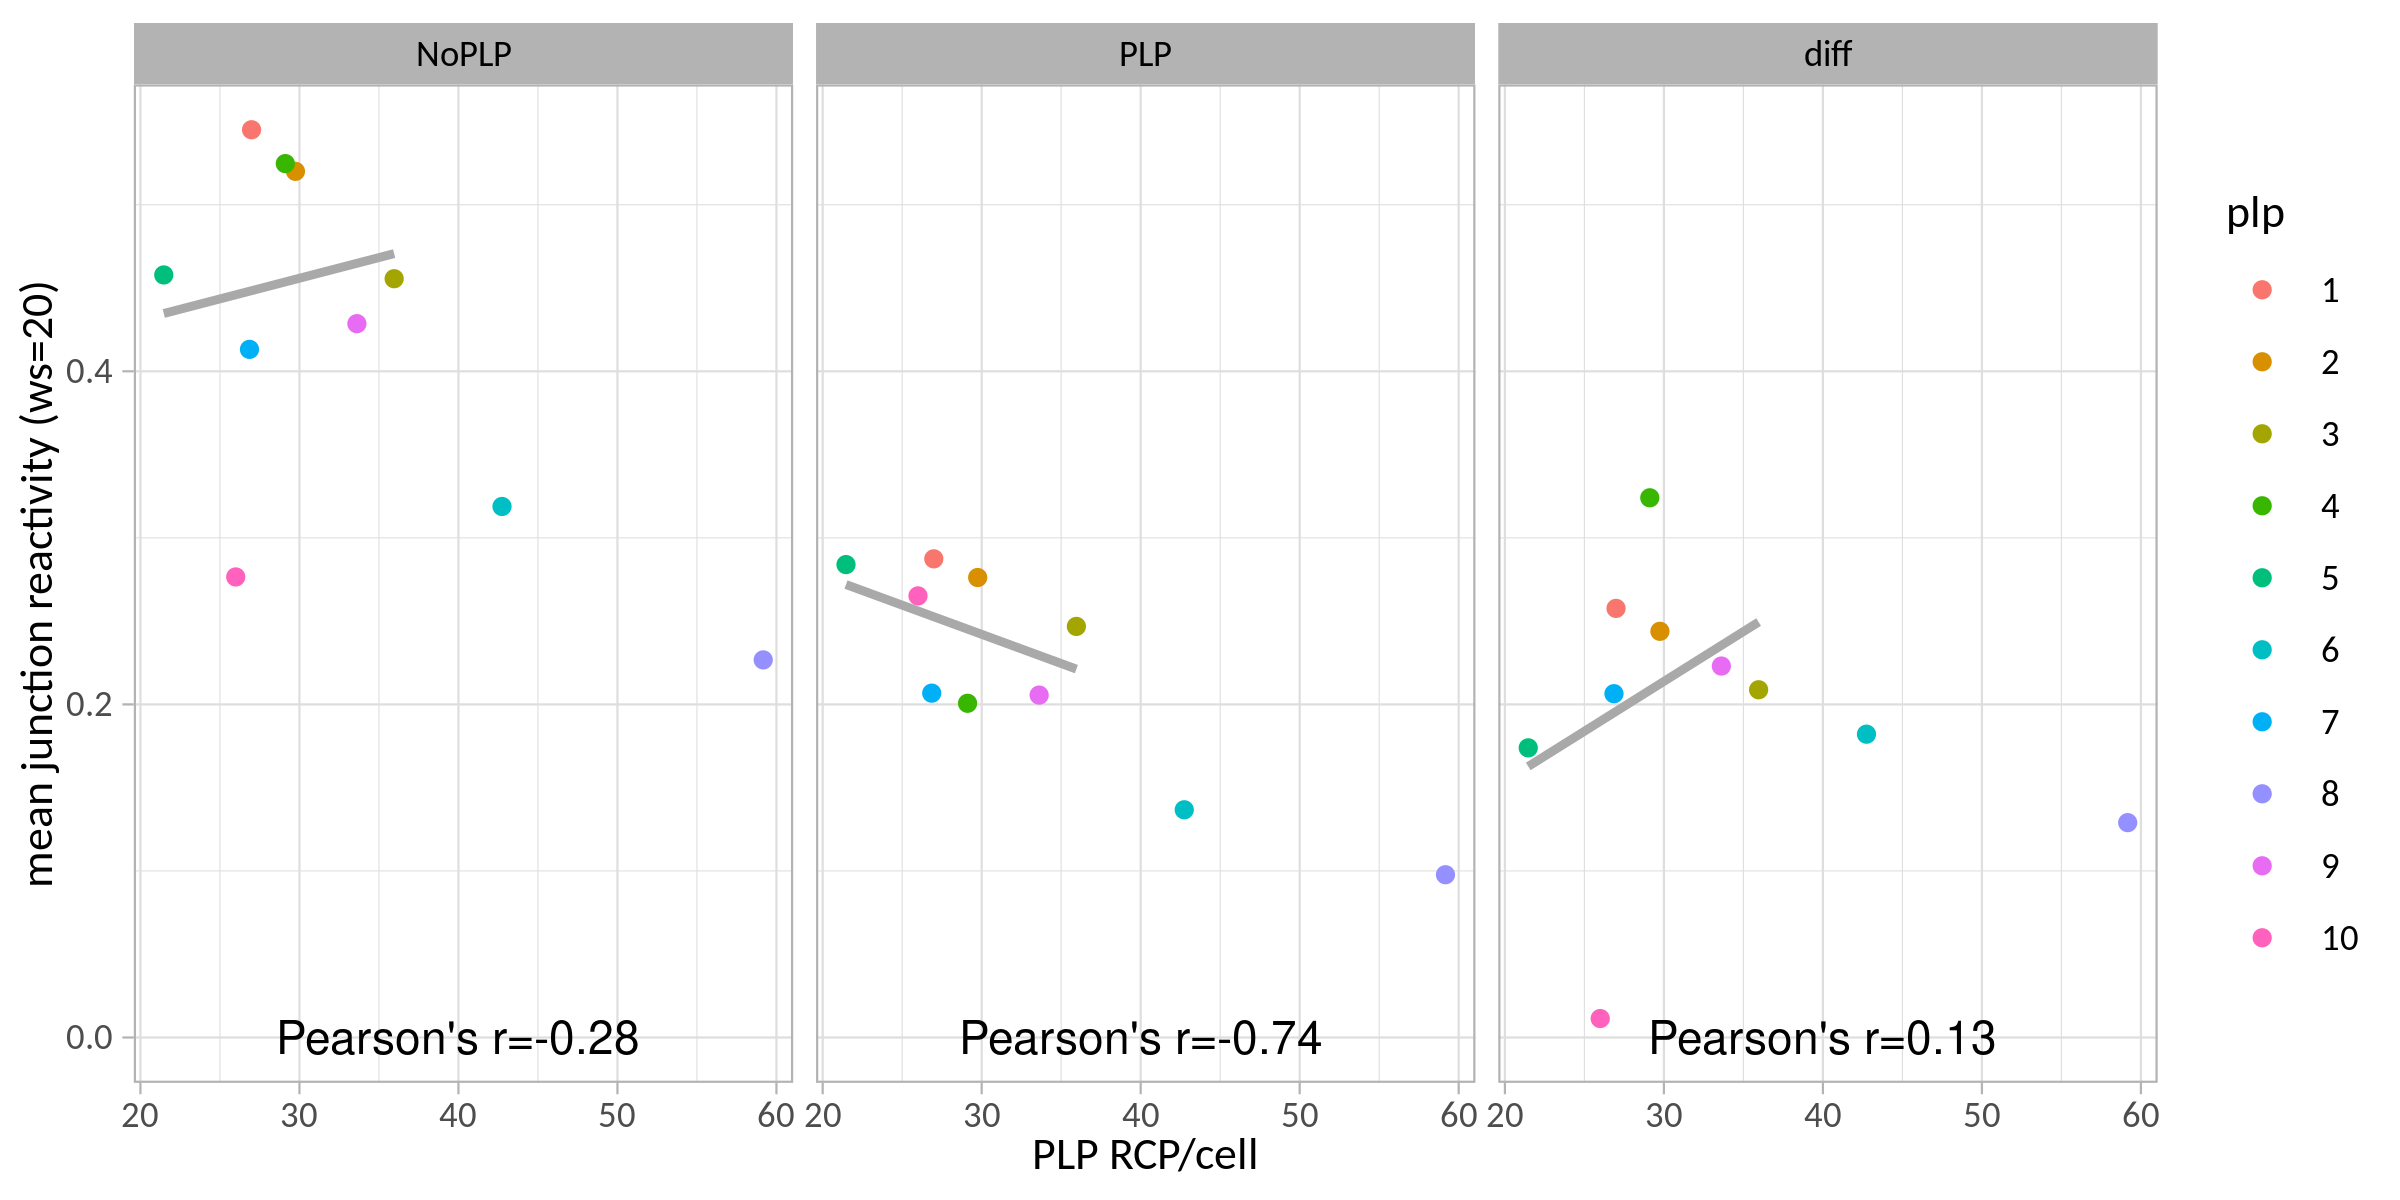

In [41]:
reactivities_ha_diff_w20 %>%
  left_join(junctions_ha) %>%
  filter(!is.na(plp)) %>%
  group_by(plp,efficiency) %>%
  summarize(across(NoPLP:diff, \(x) mean(x, na.rm=TRUE)), .groups="drop") %>%
  mutate(plp = as_factor(plp)) %>%
  pivot_longer(NoPLP:diff,values_to="mean reactivity") %>%
  mutate(name = fct_relevel(name, "NoPLP", "PLP")) %>%
  ggplot(aes(efficiency, `mean reactivity`)) +
    geom_smooth(data=. %>% filter(!plp %in% c(6,8)), method="lm", se=FALSE, color="darkgray") +
    geom_point(aes(color=plp)) +
    facet_wrap(name~.) +
    geom_text(data=mutate(correlation_junction_reactivity,name=term,x=40,y=0,efficiency=round(efficiency,2),name=fct_relevel(name,"NoPLP","PLP")), aes(x=x,y=y,label=str_glue("Pearson's r={efficiency}")), inherit.aes = FALSE) +
    ylab("mean junction reactivity (ws=20)") +
    xlab("PLP RCP/cell")

In [30]:
ggsave("figures/supp-fig4c-plp_reactivity_efficiency_correlation-junction-HA.svg", width = 8, height = 4, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'
